In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms
import torchvision.datasets as datasets

import torch.utils.data as data
import torchsummary
import matplotlib.pyplot as plt
import numpy as np
import copy
import pandas as pd

from models.resnet10 import ResNet10 
from models.resnet18 import ResNet18
from models.resnet12 import ResNet12
from models.resnet14_4 import ResNet14_4
from models.resnet14_5 import ResNet14_5
from models.resnet10 import BasicBlock as BasicBlock10
from models.resnet18 import BasicBlock as BasicBlock18
from models.resnet12 import BasicBlock

ModuleNotFoundError: ignored

In [ ]:
# Compute means and standard deviations along the R,G,B channel
ROOT = "/CIFAR10/"
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

100%|██████████| 170498071/170498071 [00:06<00:00, 28062096.36it/s]


Extracting /CIFAR10/cifar-10-python.tar.gz to /CIFAR10/


In [ ]:
print(means)
print(stds)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [ ]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

In [ ]:
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

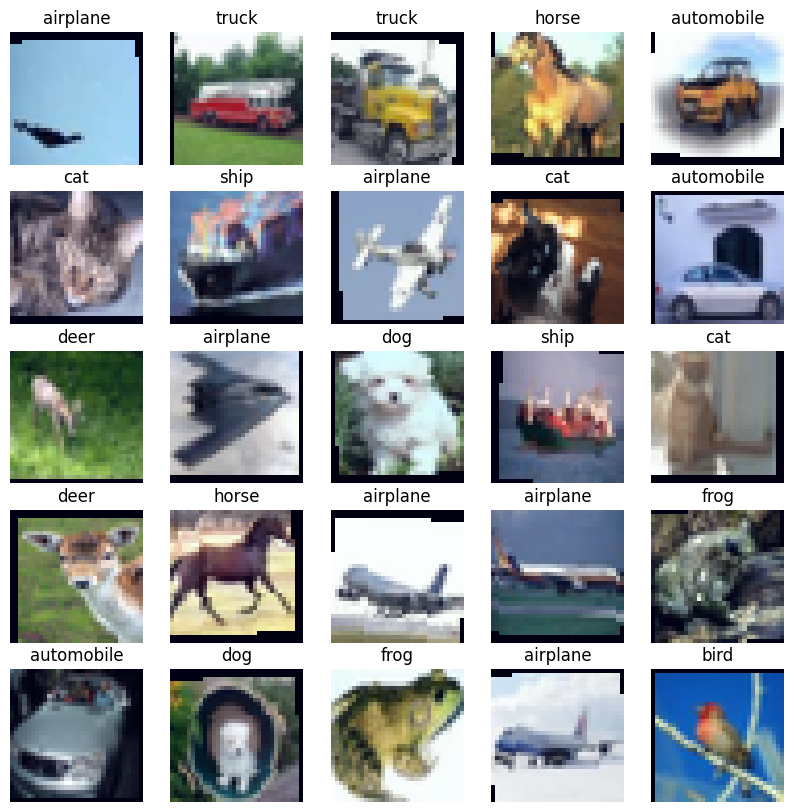

In [ ]:
plot_images(images, labels, classes, normalize = True)

In [ ]:
BATCH_SIZE = 256

train_iterator = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_iterator = torch.utils.data.DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False)
test_iterator = torch.utils.data.DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = ResNet18()
#model = model.to(device)

In [ ]:
#sum(p.numel() for p in model.parameters() if p.requires_grad)

4980234

In [ ]:
#torchsummary.summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,928
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2d-14          [-1, 128,

In [ ]:
# def initialize_parameters(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
#         nn.init.constant_(m.bias.data, 0)
#     elif isinstance(m, nn.Linear):
#         nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
#         nn.init.constant_(m.bias.data, 0)

In [ ]:
#model.apply(initialize_parameters)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential

In [ ]:
# learning_rate = 0.001
# curr_lr = learning_rate
# optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# criterion = nn.CrossEntropyLoss()

# model = model.to(device)
# criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def save_to_excel(data, table_name):
  df = pd.DataFrame(data=data)
  df = df.T

  df.to_excel(f'./results/{table_name}.xlsx')

In [1]:
def run_exp(model, optimizer, learning_rate, curr_lr, table_name = '', EPOCHS = 50):

  max_validation_accuracy = 0
  train_losses = []
  valid_losses = []
  valid_accuracies = []

  for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    print(f'Epoch {epoch}, Train loss {train_loss}, Train accuracy {train_acc}, Validation loss {valid_loss}, Validation accuracy {valid_acc}')

    if(valid_acc >= max_validation_accuracy):
      print(f"Validation accuracy increased from {max_validation_accuracy:.2f} to {valid_acc:.2f}")
      max_validation_accuracy = valid_acc
      torch.save(model.state_dict(), table_name+str(epoch)+'.ckpt')

    if (epoch+1) % 20 == 0:
          curr_lr /= 3
          update_lr(optimizer, curr_lr)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    save_to_excel([train_losses,valid_losses,valid_accuracies], table_name+str(epoch))

  return train_losses, valid_losses, valid_accuracies

In [5]:
def main():
  learning_rate = [0.1, 0.01, 0.001]
  optimizers = ['Adam', 'SGD', 'AdaDelta']
  for lr in learning_rate:
    for optimizer in optimizer:
      resnet10 = ResNet10(BasicBlock10, [2, 1, 1, 1]).to(device)
      resnet18 = ResNet18(BasicBlock18, [2, 2, 2, 2]).to(device)
      resnet12 = ResNet12(BasicBlock, [2, 2, 2]).to(device)
      resnet14_4 = ResNet14_4(BasicBlock, [2, 2, 2, 1]).to(device)
      resnet14_5 = ResNet14_5(BasicBlock, [2, 3, 3, 1, 1]).to(device)

      if optimizer == 'Adam':
        opt_10 = optim.Adam(resnet10.parameters(), lr = lr)
        opt_12 = optim.Adam(resnet12.parameters(), lr = lr)
        opt_14_4 = optim.Adam(resnet14_4.parameters(), lr = lr)
        opt_14_5 = optim.Adam(resnet14_5.parameters(), lr = lr)
        opt_18 = optim.Adam(resnet18.parameters(), lr = lr)
      elif optimizer == 'SGD':
        opt_10 = optim.SGD(resnet10.parameters(), lr = lr, weight_decay= 0.0001, momentum = 0.9)
        opt_12 = optim.SGD(resnet12.parameters(), lr = lr, weight_decay= 0.0001, momentum = 0.9)
        opt_14_4 = optim.SGD(resnet14_4.parameters(), lr = lr, weight_decay= 0.0001, momentum = 0.9)
        opt_14_5 = optim.SGD(resnet14_5.parameters(), lr = lr, weight_decay= 0.0001, momentum = 0.9)
        opt_18 = optim.SGD(resnet18.parameters(), lr = lr, weight_decay= 0.0001, momentum = 0.9)
      elif optimizer == 'AdaDelta':
        opt_10 = optim.Adadelta(resnet10.parameters(), lr=lr, weight_decay=0.0001)
        opt_12 = optim.Adadelta(resnet12.parameters(), lr=lr, weight_decay=0.0001)
        opt_14_4 = optim.Adadelta(resnet14_4.parameters(), lr=lr, weight_decay=0.0001)
        opt_14_5 = optim.Adadelta(resnet14_5.parameters(), lr=lr, weight_decay=0.0001)
        opt_18 = optim.Adadelta(resnet18.parameters(), lr=lr, weight_decay=0.0001)
       
      run_exp(resnet10, opt_10, lr, lr, 'resnet10_'+optimizer+'_'+str(lr), EPOCHS = 2)
      run_exp(resnet18, opt_18, lr, lr, 'resnet18_'+optimizer+'_'+str(lr), EPOCHS = 2)
      run_exp(resnet12, opt_12, lr, lr, 'resnet12_'+optimizer+'_'+str(lr), EPOCHS = 2)
      run_exp(resnet14_4, opt_14_4, lr, lr, 'resnet14_4_'+optimizer+'_'+str(lr), EPOCHS = 2)
      run_exp(resnet14_5, opt_14_5, lr, lr, 'resnet14_5'+optimizer+'_'+str(lr), EPOCHS = 2)

      test_loss, test_acc = evaluate(resnet10, test_iterator, criterion, device)
      print('Test loss: ' + {test_loss}, 'Test accuracy: ' + {test_acc}, ' resnet10_'+optimizer+'_'+str(lr))
      test_loss, test_acc = evaluate(resnet18, test_iterator, criterion, device)
      print('Test loss: ' + {test_loss}, 'Test accuracy: ' + {test_acc}, ' resnet18_'+optimizer+'_'+str(lr))
      test_loss, test_acc = evaluate(resnet12, test_iterator, criterion, device)
      print('Test loss: ' + {test_loss}, 'Test accuracy: ' + {test_acc}, ' resnet12_'+optimizer+'_'+str(lr))
      test_loss, test_acc = evaluate(resnet14_4, test_iterator, criterion, device)
      print('Test loss: ' + {test_loss}, 'Test accuracy: ' + {test_acc}, ' resnet14_4_'+optimizer+'_'+str(lr))
      test_loss, test_acc = evaluate(resnet14_5, test_iterator, criterion, device)
      print('Test loss: ' + {test_loss}, 'Test accuracy: ' + {test_acc}, ' resnet14_5_'+optimizer+'_'+str(lr))